# Packages

#### Libraries

In [14]:
# Visualisation
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from pyvis.network import Network

# Data analysis / Data processing
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.4f}".format
from datetime import time, timedelta, datetime
import numpy as np
import networkx as nx
from collections import defaultdict
import ast
from ydata_profiling import ProfileReport

# Maths & Stats
import math 
import scipy.stats as st
from scipy import stats
from scipy.stats import norm
import statsmodels.stats.weightstats as ws
from statsmodels.stats.proportion import test_proportions_2indep
import AB_library
import random

# System library
import os
import ipywidgets
import warnings
import pandas_gbq
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
tqdm.pandas()
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format='retina'
# from itables import init_notebook_mode
# init_notebook_mode(all_interactive=True)
import openpyxl

# Data connection
from google.cloud import bigquery
bigquery_client = bigquery.Client(project='analytics-dev-333113')


# Useful functions
def cycle_sql(start, end, query, weeks=False):
    """
    You have to use {date} in your script to add cycle date into this backets
    """
    date_start = datetime.strptime(start, '%Y-%m-%d')
    date_end = datetime.strptime(end, '%Y-%m-%d')

    if weeks == False:
        daterange = [(date_start + timedelta(days=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days)+1)]
    else:
        daterange = [(date_start + timedelta(weeks=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days//7)+1)] # weeks dividing days by 7

    total_df = pd.DataFrame()

    counter = 0

    for date in daterange:
        counter+=1
        print(f"{counter}) Uploading - {date}:", datetime.today().strftime('%Y-%m-%d %H:%M:%S'))
        script = query.format(date = date)
        df_cycle = bigquery_client.query(script).to_dataframe()
        if df_cycle.empty == True:
            print('Dataframe is empty')
        total_df = pd.concat([df_cycle, total_df])
    return total_df

def read_bq(query, project='analytics-dev-333113'):
    client = bigquery.Client(project=project)
    query_job = client.query(query)
    result_df = query_job.to_dataframe()
    return result_df

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(
        html_str.replace('table','table style="display:inline"'), 
        raw=True
    )

def writing_excel(name:str, dataset1=None, dataset2=None, dataset3=None, dataset4=None):
    with pd.ExcelWriter(f"{name}.xlsx") as writer:

    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet

        if dataset1 is not None:
            if dataset2 is not None:
                if dataset3 is not None:
                    if dataset4 is not None:
                        dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                        #   index=False
                                            )
                        dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                        #   index=False
                                            )
                        dataset3.to_excel(writer, sheet_name=f"3-{name}", 
                                        #   index=False
                                            )
                        dataset4.to_excel(writer, sheet_name=f"4-{name}", 
                                        #   index=False
                                            )
                    else:
                        dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                        #   index=False
                                            )
                        dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                        #   index=False
                                            )
                        dataset3.to_excel(writer, sheet_name=f"3-{name}", 
                                        #   index=False
                                            )
                else:
                    dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                    #   index=False
                                        )
                    dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                    #   index=False
                                        )
            else:
                dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                #   index=False
                                    )

        print('DataFrame is written to Excel File successfully.') 

#### Table preparation

In [ ]:
code_creation = """
CREATE TABLE analytics-dev-333113.renat_yunisov.lgb_results_safety_scoring
(
    ride_uuid                           STRING,
    night_time_flg                      BOOL,
    contractor_id                       INT64,
    driver_reg_date                     DATE,
    customer_id                         INT64,
    user_reg_date                       DATE,
    order_city_id                       INT64,
    order_country_id                    INT64,
    DEVIATION_TYPE_RIDE_STOP_1          INT64,
    DEVIATION_TYPE_RIDE_STOP_2          INT64,
    DEVIATION_TYPE_RIDE_STOP_3          INT64,
    RIDE_LATE_1                         INT64,
    RIDE_LATE_2                         INT64,
    RIDE_LATE_3                         INT64,
    DEVIATION_TYPE_RIDE_EARLY_1         INT64,
    DEVIATION_TYPE_RIDE_ROUTE_CHANGES_1 INT64,
    max_seconds_of_stop                 INT64,
    danger_zone_flag                    BOOL,
    number_of_danger_zone               INT64,
    redmine_id                          STRING,
    incident_level                      STRING,
    incident_type                       STRING,
    category                            STRING,
    level_harm_health                   STRING
) OPTIONS (
    EXPIRATION_TIMESTAMP = TIMESTAMP '2025-12-01 00:00:00 UTC',
    DESCRIPTION = 'temp table for the analytics on in-trip monitoring')
"""

# code = """
# WITH deviations AS (SELECT t1.ride_uuid,
#                            t2.driver_reg_date,
#                            t1.contractor_id,
#                            t2.user_reg_date,
#                            t1.customer_id,
#                            t2.order_city_id,
#                            t2.order_country_id,
#                            COALESCE(t1.deviation_type, 'RIDE_LATE')                                AS deviation_type,
#                            t1.deviation_level,
#                            (COALESCE(t1.deviation_type, 'RIDE_LATE') || '_' || t1.deviation_level) AS category,
#                            t1.create_at,
#                            DATETIME(t1.create_at, t3.timezone)                                     AS local_time,
#                            driverstarttheride_timestamp,
#                            IF(EXTRACT(HOUR FROM DATETIME(t1.create_at, t3.timezone)) IN
#                               (20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6), 1,
#                               0)                                                                   AS night_time,
#                            AVG(IF(EXTRACT(HOUR FROM DATETIME(t1.create_at, t3.timezone)) IN
#                                   (20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6), 1,
#                                   0))
#                                OVER (PARTITION BY t1.ride_uuid)                                    AS night_time_corrected
#                     FROM indriver-e6e40.ods_in_trip_monitoring_cdc.ride_deviation_global t1
#                              JOIN (SELECT order_uuid,
#                                           user_id    AS pass_id,
#                                           driver_id,
#                                           city_id    AS order_city_id,
#                                           country_id AS order_country_id,
#                                           status_order,
#                                           order_timestamp,
#                                           at_pickup_dttm,
#                                           departed_pickup_dttm,
#                                           at_destination_dttm,
#                                           departed_destination_dttm,
#                                           driveraccept_timestamp,
#                                           driverarrived_timestamp,
#                                           driverstarttheride_timestamp,
#                                           driverdone_timestamp,
#                                           clientdone_timestamp,
#                                           user_reg_date,
#                                           driver_reg_date,
#                                           created_date_order_part,
#                                    FROM indriver-e6e40.imart.incity_detail_new_order t1
#                                    WHERE created_date_order_part BETWEEN '2025-03-01' AND '2025-06-01') t2
#                                   ON t1.contractor_id = t2.driver_id AND t1.customer_id = t2.pass_id AND
#                                      (DATE(t1.create_at) BETWEEN DATE_ADD(created_date_order_part, INTERVAL -1 DAY) AND DATE_ADD(created_date_order_part, INTERVAL +1 DAY))
#                                       AND t1.create_at > t2.driverstarttheride_timestamp
#                              JOIN indriver-e6e40.ods_monolith.tbl_city t3
#                                   ON
#                                       t2.order_city_id = t3.id
#                     WHERE DATE(create_at) BETWEEN '2025-03-01' AND '2025-06-01'),
#      stops AS (SELECT t1.driver_id,
#                       t1.passenger_id,
#                       t1.ride_uuid,
#                       MAX(seconds_of_stop)                   AS max_seconds_of_stop,
#                       MAX(IF(danger_zone_flag = TRUE, 1, 0)) AS danger_zone_flag,
#                       SUM(IF(danger_zone_flag = TRUE, 1, 0)) AS number_of_danger_zone
#                FROM indriver-e6e40.ods_in_trip_monitoring_cdc.ride_deviation_event_stop_global t1
#                         JOIN (SELECT user_id, driver_id, created_date_order_part, driverstarttheride_timestamp
#                               FROM indriver-e6e40.imart.incity_detail_new_order
#                               WHERE created_date_order_part BETWEEN '2025-03-01' AND '2025-06-01') t2
#                              ON t1.driver_id = t2.driver_id AND t1.passenger_id = t2.user_id AND
#                                 DATE(create_at) BETWEEN DATE_ADD(created_date_order_part, INTERVAL -1 DAY) AND DATE_ADD(created_date_order_part, INTERVAL +1 DAY)
#                WHERE DATE(create_at) BETWEEN '2025-03-01' AND '2025-06-01'
#                  AND t1.create_at > t2.driverstarttheride_timestamp
#                GROUP BY 1, 2, 3),
#      incidents AS (SELECT pass_id,
#                           driver_id,
#                           'driver' AS aggressor,
#                           redmine_id,
#                           incident_type,
#                           incident_level,
#                           information_status,
#                           category,
#                           level_harm_health,
#                           incident_date,
#                           city_id,
#                           city_name,
#                           country_name,
#                    FROM indriver-bi.safety.vw_safety_incidents_detail
#                    WHERE incident_date >= '2024-12-30'
#                      AND information_status NOT IN ('FALSE', 'False')
#                      AND aggressor = 'Driver'),
#      features AS (SELECT *
#                   FROM (SELECT ride_uuid,
#                                IF(night_time_corrected >= 0.5, 1, 0) AS night_time_flg,
#                                contractor_id,
#                                driver_reg_date,
#                                customer_id,
#                                user_reg_date,
#                                order_city_id,
#                                order_country_id,
#                                category,
#                                COUNT(local_time)                     AS events
#                         FROM deviations
#                         GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9)
#                       PIVOT (SUM(events) FOR category IN (
#                           'DEVIATION_TYPE_RIDE_STOP_1',
#                           'DEVIATION_TYPE_RIDE_STOP_2',
#                           'DEVIATION_TYPE_RIDE_STOP_3',
#                           'RIDE_LATE_1',
#                           'RIDE_LATE_2',
#                           'RIDE_LATE_3',
#                           'DEVIATION_TYPE_RIDE_EARLY_1',
#                           'DEVIATION_TYPE_RIDE_ROUTE_CHANGES_1')))
# SELECT t1.ride_uuid,
#        night_time_flg,
#        contractor_id,
#        driver_reg_date,
#        customer_id,
#        user_reg_date,
#        order_city_id,
#        order_country_id,
#        DEVIATION_TYPE_RIDE_STOP_1,
#        DEVIATION_TYPE_RIDE_STOP_2,
#        DEVIATION_TYPE_RIDE_STOP_3,
#        RIDE_LATE_1,
#        RIDE_LATE_2,
#        RIDE_LATE_3,
#        DEVIATION_TYPE_RIDE_EARLY_1,
#        DEVIATION_TYPE_RIDE_ROUTE_CHANGES_1,
#        max_seconds_of_stop,
#        danger_zone_flag,
#        number_of_danger_zone,
#        IF(redmine_id IS NOT NULL, 1, 0) AS incident_flag,
#        redmine_id,
#        incident_level,
#        information_status,
#        incident_type,
#        category,
#        level_harm_health
# FROM features t1
#          LEFT JOIN stops t2 ON t1.ride_uuid = t2.ride_uuid AND t1.contractor_id = t2.driver_id AND
#                                t1.customer_id = t2.passenger_id
#          LEFT JOIN incidents t3 ON t1.contractor_id = t3.driver_id AND t1.customer_id = t3.pass_id
# """

# date_start = datetime.strptime('2025-03-01', '%Y-%m-%d')
# date_end = datetime.strptime('2025-04-30', '%Y-%m-%d')


# daterange = [(date_start + timedelta(days=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days)+1)]

# total_df = pd.DataFrame()

# counter = 0

# for date in daterange:
#     counter+=1
#     print(f"{counter}) Uploading - {date}:", datetime.today().strftime('%Y-%m-%d %H:%M:%S'))
#     script = code.format(date = date)

#     df_cycle = bigquery_client.query(script).to_dataframe()

#     if df_cycle.empty == True:
#         print('Dataframe is empty')

#     pandas_gbq.to_gbq(df_cycle,
#                     destination_table='renat_yunisov.temp_table_itm',
#                     project_id='analytics-dev-333113',
#                     if_exists='append')
#     print('Dataframe was uploaded', datetime.today().strftime('%Y-%m-%d %H:%M:%S'))


# Driver as an aggressor

In [ ]:
# df = read_bq("""
# SELECT ride_uuid,
#        night_time_flg,
#        contractor_id,
#        driver_reg_date,
#        customer_id,
#        user_reg_date,
#        order_city_id,
#        order_country_id,
#        DEVIATION_TYPE_RIDE_STOP_1,
#        DEVIATION_TYPE_RIDE_STOP_2,
#        DEVIATION_TYPE_RIDE_STOP_3,
#        RIDE_LATE_1,
#        RIDE_LATE_2,
#        RIDE_LATE_3,
#        DEVIATION_TYPE_RIDE_EARLY_1,
#        DEVIATION_TYPE_RIDE_ROUTE_CHANGES_1,
#        max_seconds_of_stop,
#        danger_zone_flag,
#        number_of_danger_zone,
#        incident_flag,
#        redmine_id,
#        incident_level,
#        information_status,
#        incident_type,
#        category,
#        level_harm_health
# FROM analytics-dev-333113.renat_yunisov.temp_table_itm
# """)

# df.head()

In [23]:
777*26

20202

In [3]:
df = pd.read_csv(
    '/Users/renatyunison/Desktop/VSC scripts/ITM_driver.csv',
    nrows=65_000_000
    )

df.head()

,ride_uuid,night_time_flg,contractor_id,driver_reg_date,customer_id,user_reg_date,order_city_id,order_country_id,DEVIATION_TYPE_RIDE_STOP_1,DEVIATION_TYPE_RIDE_STOP_2,DEVIATION_TYPE_RIDE_STOP_3,RIDE_LATE_1,RIDE_LATE_2,RIDE_LATE_3,DEVIATION_TYPE_RIDE_EARLY_1,DEVIATION_TYPE_RIDE_ROUTE_CHANGES_1,max_seconds_of_stop,danger_zone_flag,number_of_danger_zone,incident_flag,redmine_id,incident_level,information_status,incident_type,category,level_harm_health
0,01965d9f-ed0f-73b6-b152-39ff65ab1f7d,0,267471181,2024-11-25,74312333,2021-02-24,5543,76,1.0000,1.0000,NaN,NaN,NaN,NaN,NaN,4.0000,999.0000,0.0000,0.0000,0,NaN,NaN,NaN,NaN,NaN,NaN
1,01958739-292e-78c2-8c39-ca92c26d8337,0,239914238,2024-06-21,188529873,2023-08-03,4199,24,1.0000,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,"1,024.0000",0.0000,0.0000,0,NaN,NaN,NaN,NaN,NaN,NaN
2,0195dd26-db09-782f-8654-c7d6ec315436,0,21063524,2019-05-11,243952812,2024-07-12,4197,22,2.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,356.0000,0.0000,0.0000,0,NaN,NaN,NaN,NaN,NaN,NaN
3,01956ffe-a749-7d19-abb2-a1dc8cfbe3b9,0,168099711,2023-03-28,182334527,2023-06-30,5910,85,4.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,343.0000,0.0000,0.0000,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0195fa9f-a94d-75ab-9530-5a3655adc906,0,196973254,2023-09-26,266243721,2024-11-18,5388,60,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,2.0000,309.0000,0.0000,0.0000,0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df['DEVIATION_TYPE_RIDE_STOP_1'] = df['DEVIATION_TYPE_RIDE_STOP_1'].fillna(0)
df['DEVIATION_TYPE_RIDE_STOP_2'] = df['DEVIATION_TYPE_RIDE_STOP_2'].fillna(0)
df['DEVIATION_TYPE_RIDE_STOP_3'] = df['DEVIATION_TYPE_RIDE_STOP_3'].fillna(0)
df['RIDE_LATE_1'] = df['RIDE_LATE_1'].fillna(0)
df['RIDE_LATE_2'] = df['RIDE_LATE_2'].fillna(0)
df['RIDE_LATE_3'] = df['RIDE_LATE_3'].fillna(0)
df['DEVIATION_TYPE_RIDE_EARLY_1'] = df['DEVIATION_TYPE_RIDE_EARLY_1'].fillna(0)
df['DEVIATION_TYPE_RIDE_ROUTE_CHANGES_1'] = df['DEVIATION_TYPE_RIDE_ROUTE_CHANGES_1'].fillna(0)
df['max_seconds_of_stop'] = df['max_seconds_of_stop'].fillna(0)
df['danger_zone_flag'] = df['danger_zone_flag'].fillna(0)
df['number_of_danger_zone'] = df['number_of_danger_zone'].fillna(0)


In [10]:
df_itm_1mln = df.sample(10_000_000)

In [55]:
df_itm_1mln.columns

Index(['ride_uuid', 'night_time_flg', 'contractor_id', 'driver_reg_date', 'customer_id', 'user_reg_date', 'order_city_id', 'order_country_id', 'DEVIATION_TYPE_RIDE_STOP_1', 'DEVIATION_TYPE_RIDE_STOP_2', 'DEVIATION_TYPE_RIDE_STOP_3', 'RIDE_LATE_1', 'RIDE_LATE_2', 'RIDE_LATE_3', 'DEVIATION_TYPE_RIDE_EARLY_1', 'DEVIATION_TYPE_RIDE_ROUTE_CHANGES_1', 'max_seconds_of_stop', 'danger_zone_flag', 'number_of_danger_zone', 'incident_flag', 'redmine_id', 'incident_level', 'information_status', 'incident_type', 'category', 'level_harm_health'], dtype='object')


Числовые признаки: ['DEVIATION_TYPE_RIDE_STOP_1', 'DEVIATION_TYPE_RIDE_STOP_2', 'DEVIATION_TYPE_RIDE_STOP_3', 'RIDE_LATE_1', 'RIDE_LATE_2', 'RIDE_LATE_3', 'DEVIATION_TYPE_RIDE_EARLY_1', 'DEVIATION_TYPE_RIDE_ROUTE_CHANGES_1']
Категориальные признаки для One-Hot Encoding: ['night_time_flg', 'danger_zone_flag']
Количество признаков после One-Hot Encoding и масштабирования: 10

Размер обучающей выборки: 8000000 строк.
Размер тестовой выборки: 2000000 строк.
Доля инцидентов в обучающей выборке: 0.0001
Доля инцидентов в тестовой выборке: 0.0001

Начинаем обучение модели Логистической Регрессии...
Обучение Логистической Регрессии завершено.

--- Анализ коэффициентов Логистической Регрессии (важность параметров) ---
Уравнение логистической регрессии:
z = -1.8756 * danger_zone_flag_1.0 + 0.5229 * night_time_flg_1 + -0.3250 + 0.2271 * DEVIATION_TYPE_RIDE_STOP_2 + 0.2061 * DEVIATION_TYPE_RIDE_STOP_3 + 0.1715 * DEVIATION_TYPE_RIDE_STOP_1 + -0.0874 * DEVIATION_TYPE_RIDE_EARLY_1 + -0.0267 * DEVIATI

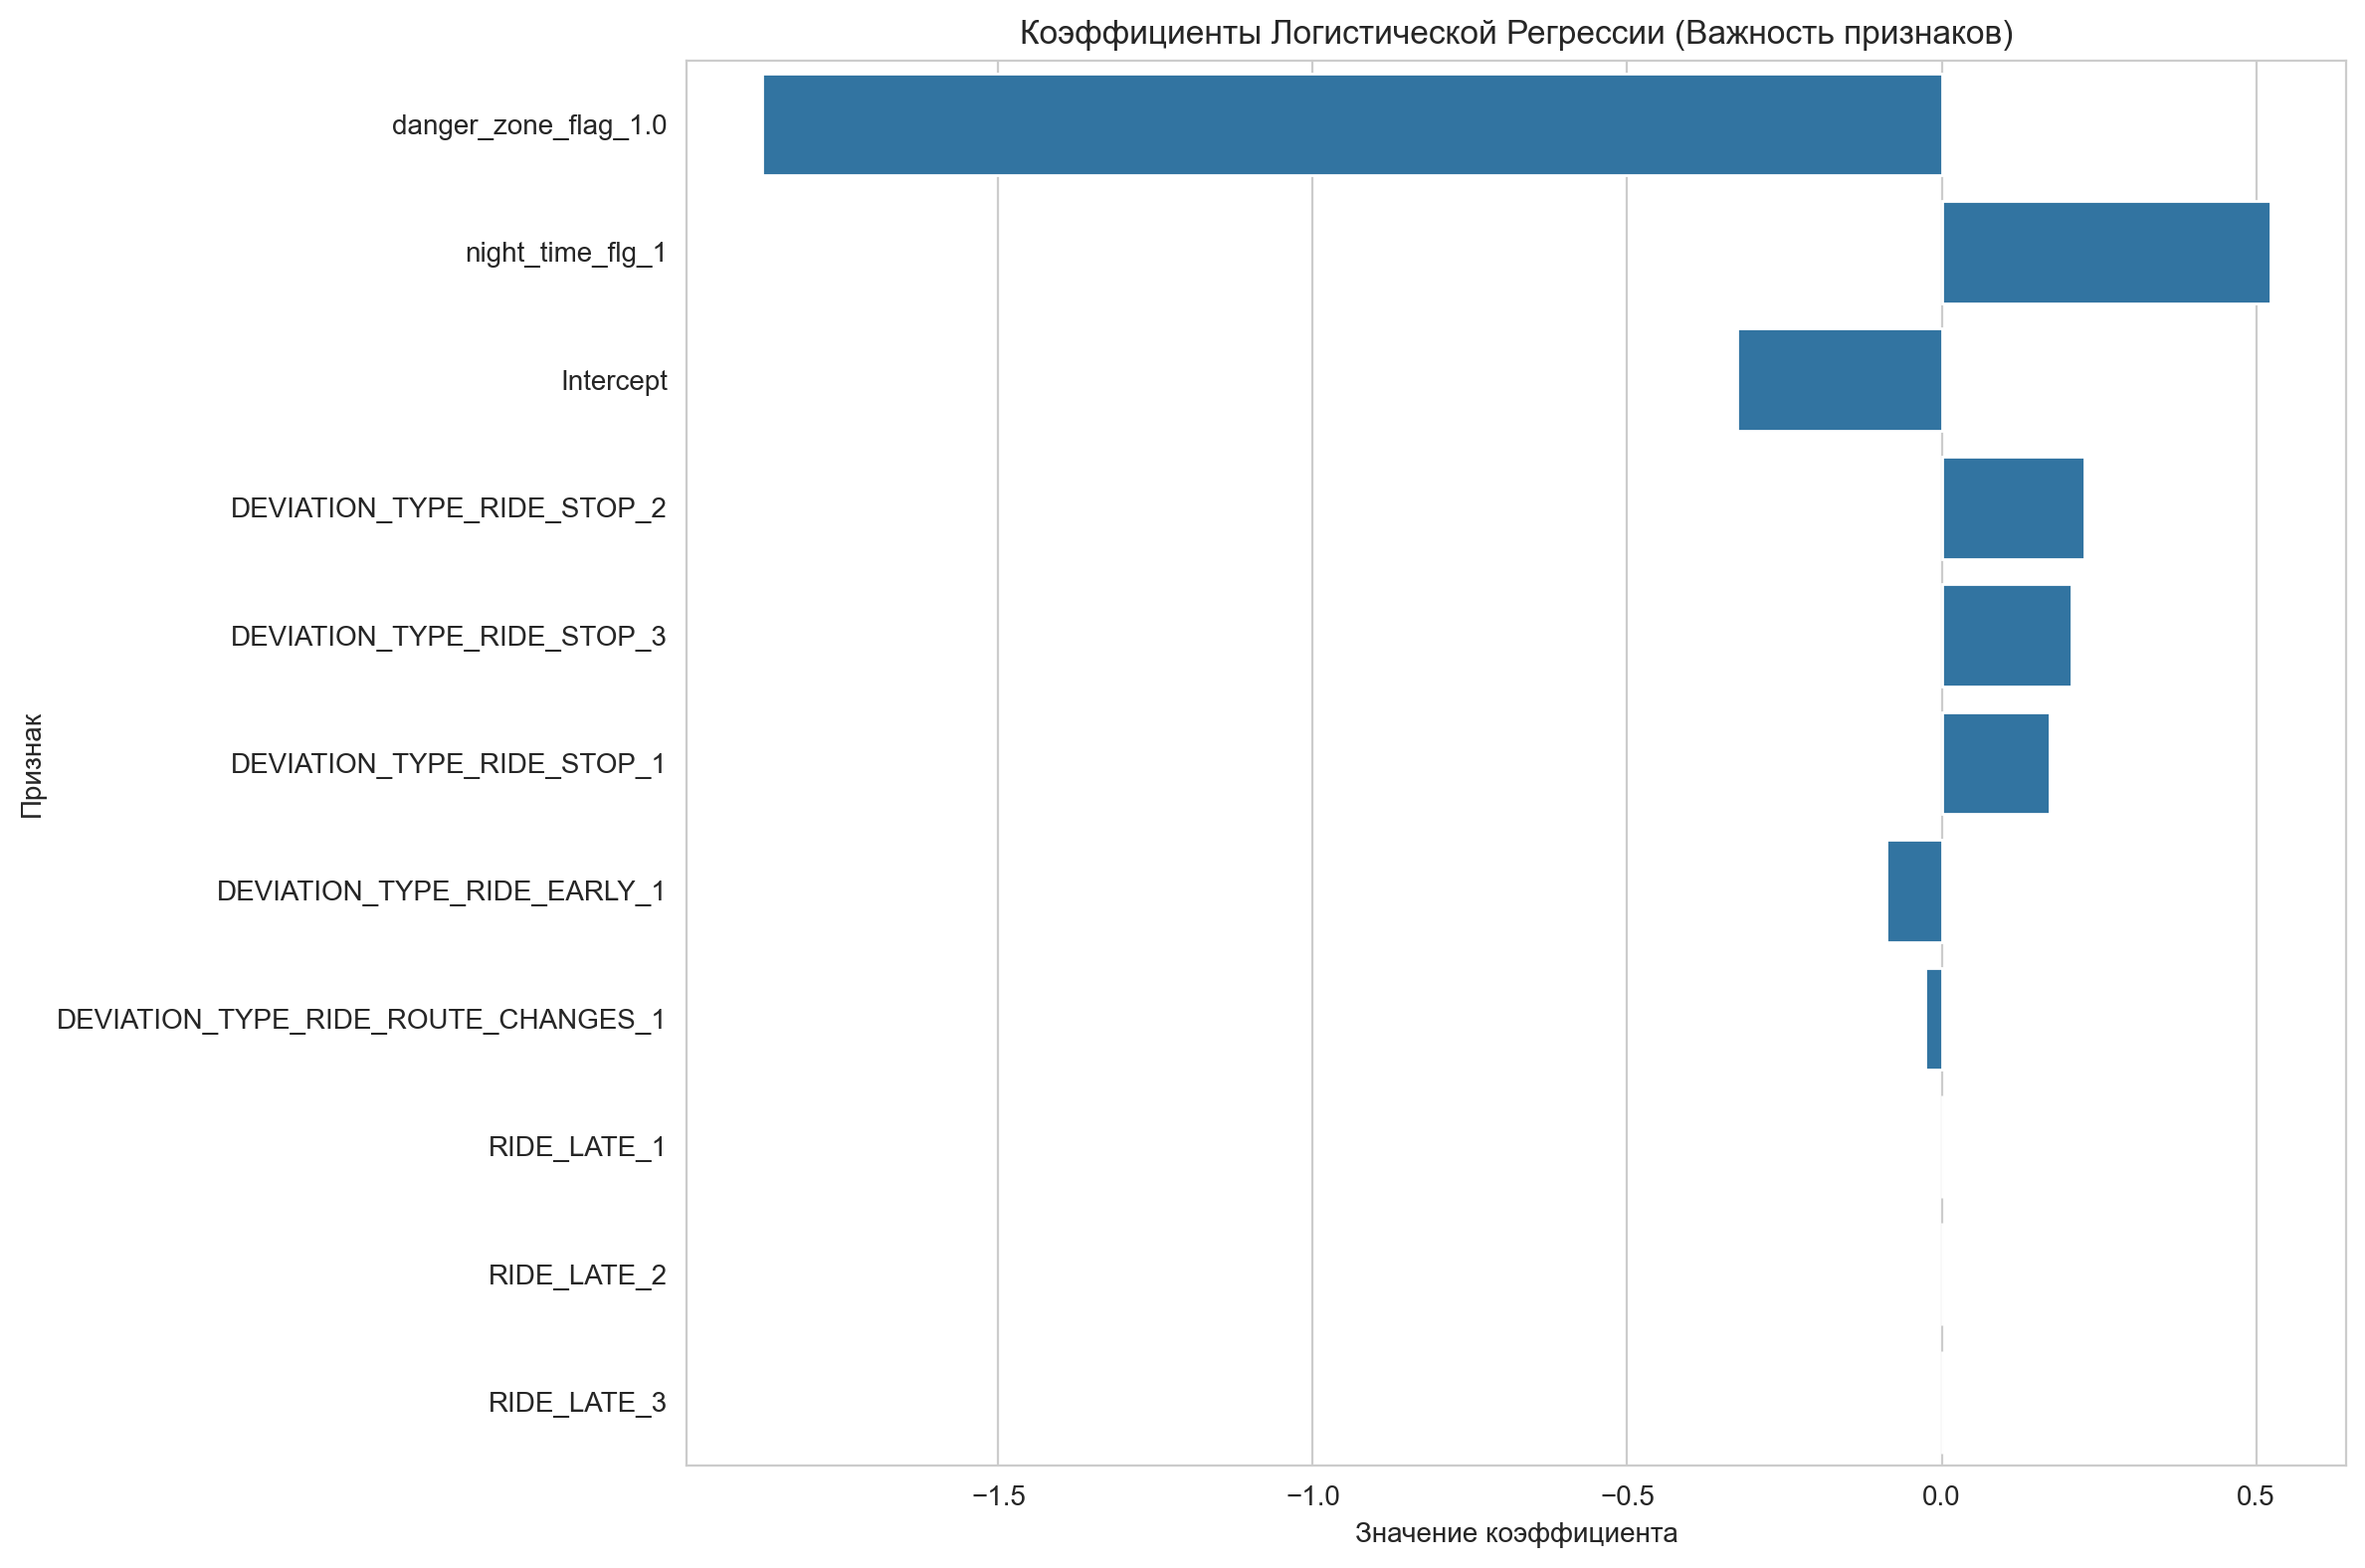


Топ-10 наиболее влиятельных признаков (по абсолютному значению коэффициента):


,Feature,Coefficient,Abs_Coefficient
9,danger_zone_flag_1.0,-1.8756,1.8756
8,night_time_flg_1,0.5229,0.5229
10,Intercept,-0.3250,0.3250
1,DEVIATION_TYPE_RIDE_STOP_2,0.2271,0.2271
2,DEVIATION_TYPE_RIDE_STOP_3,0.2061,0.2061
0,DEVIATION_TYPE_RIDE_STOP_1,0.1715,0.1715
6,DEVIATION_TYPE_RIDE_EARLY_1,-0.0874,0.0874
7,DEVIATION_TYPE_RIDE_ROUTE_CHANGES_1,-0.0267,0.0267
3,RIDE_LATE_1,0.0000,0.0000
4,RIDE_LATE_2,0.0000,0.0000



--- Оценка модели по различным порогам (включая FPR, FNR) ---


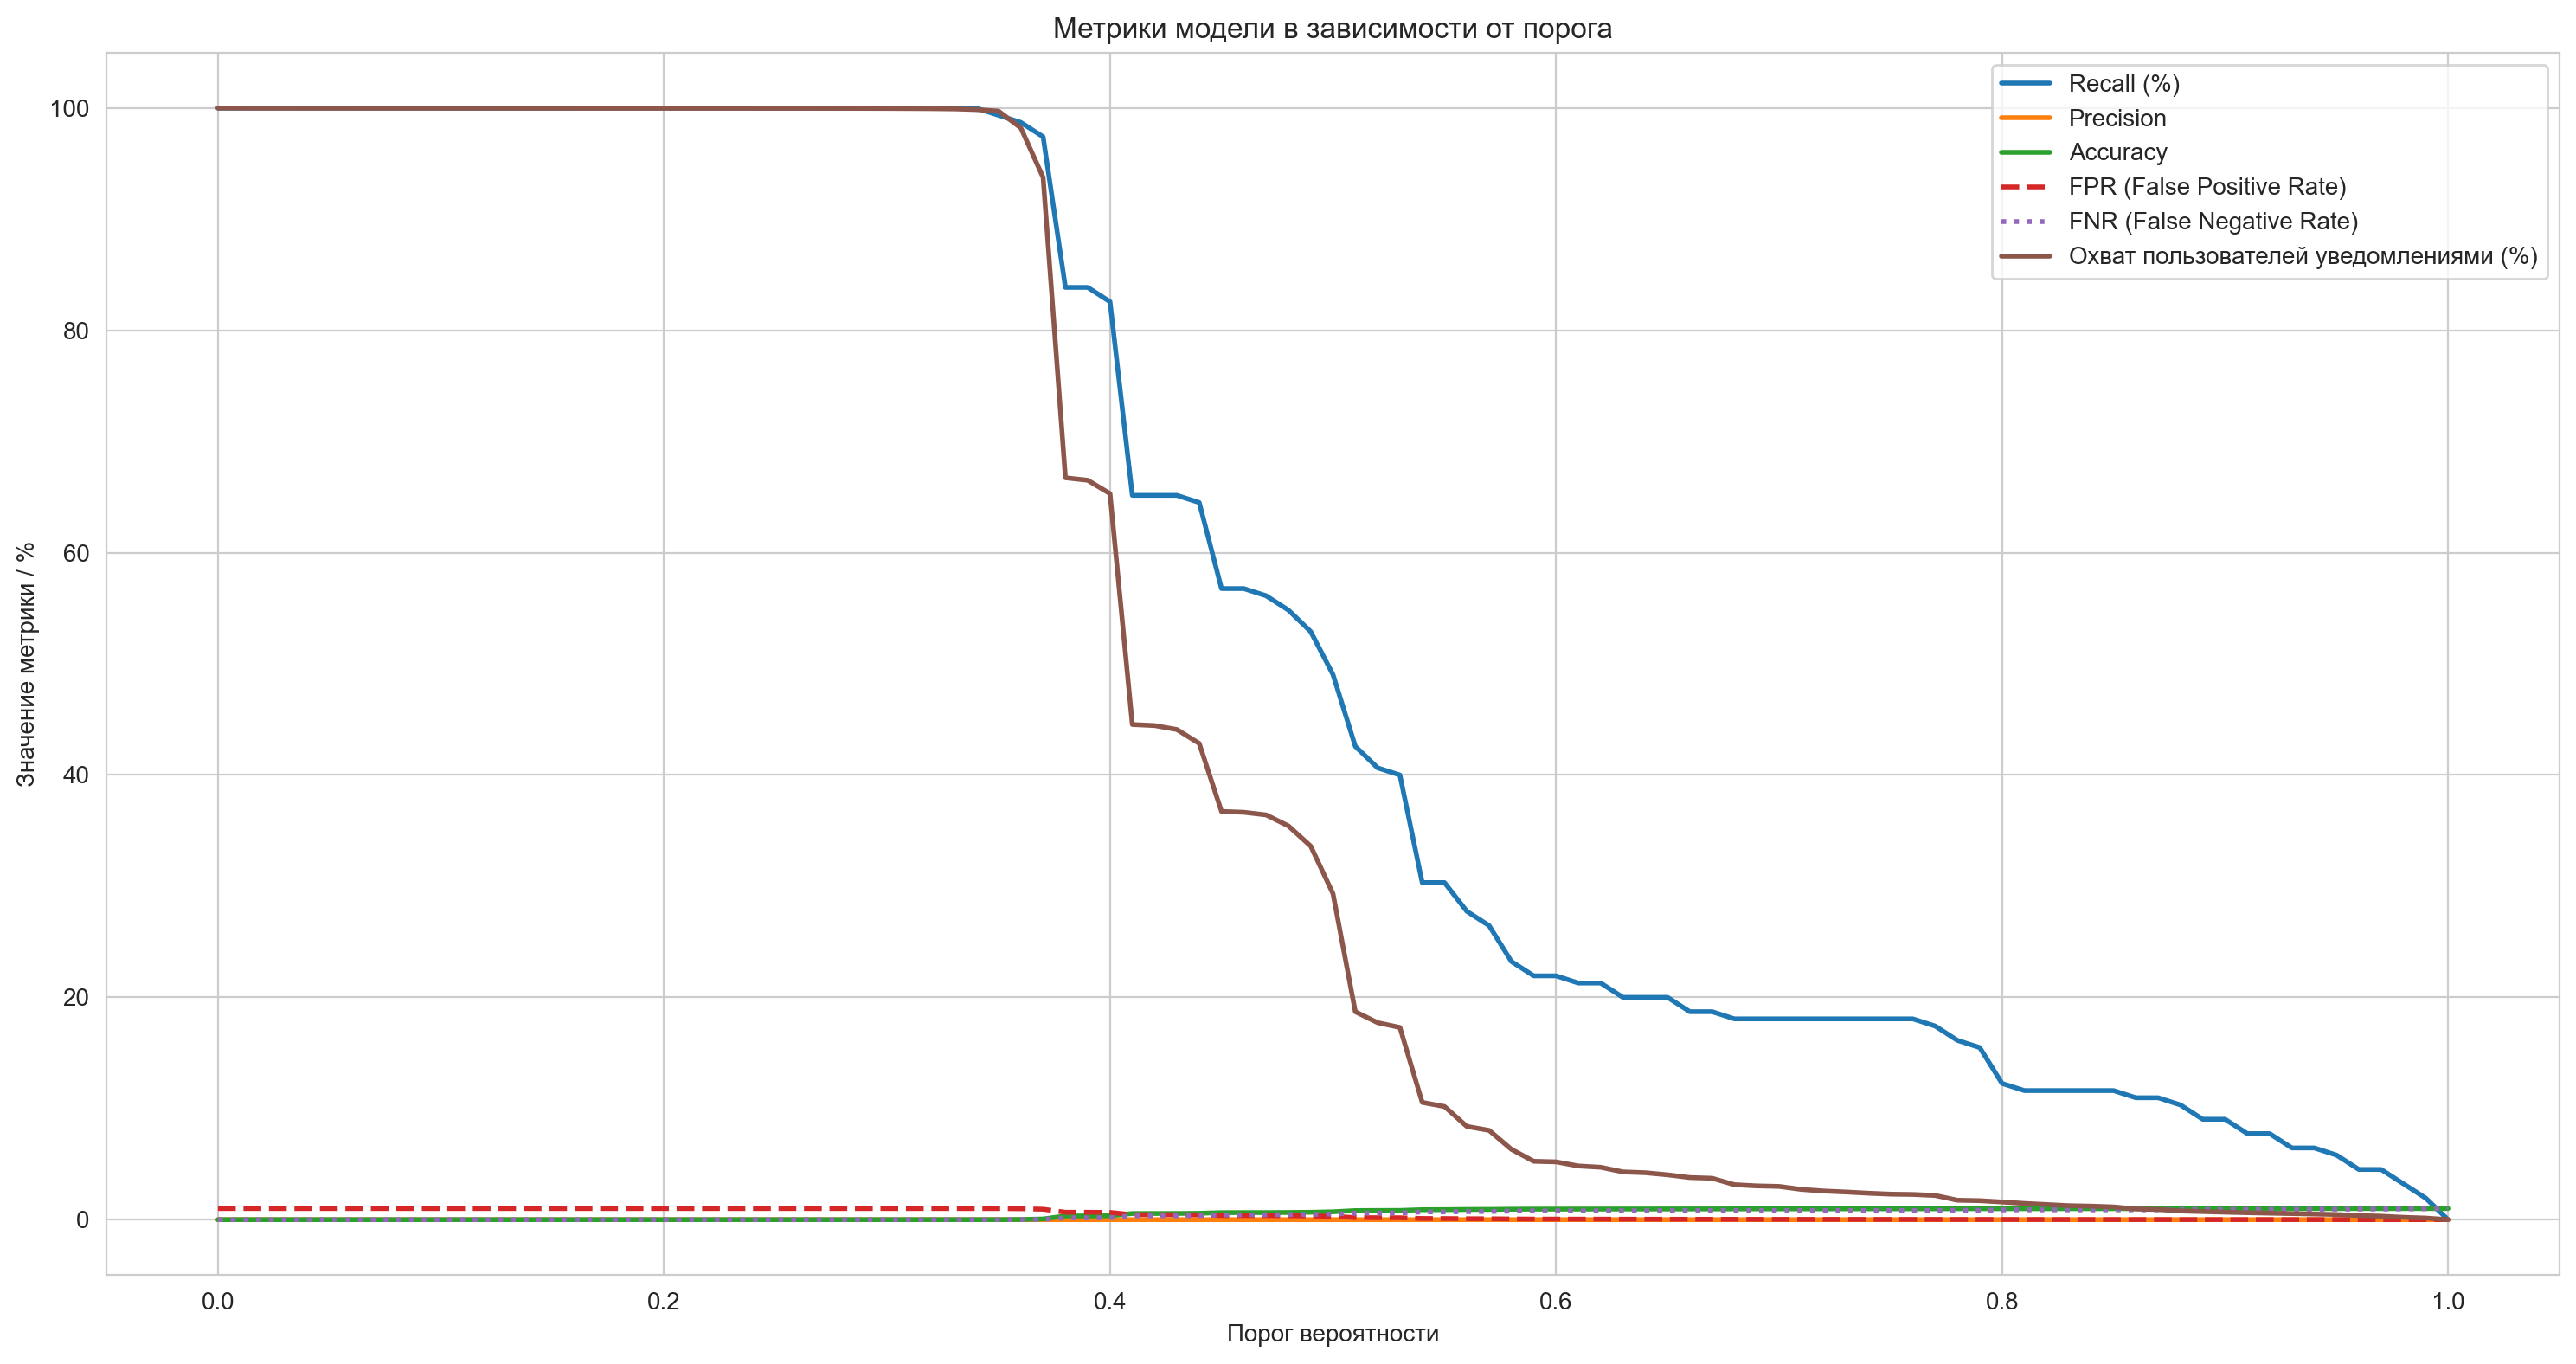


Таблица метрик для различных порогов:


,Threshold,"Recall (Полнота, % пойманных инцидентов)",Precision (Точность уведомлений),Accuracy,F1-Score,FPR (Ложные уведомления среди не-инцидентов),FNR (Пропуски среди инцидентов),User Notification Coverage (% от всех поездок),Кол-во поездок,Кол-во пойманных инцидентов,True Positives (TP),False Positives (FP),False Negatives (FN),True Negatives (TN)
0,0.0000,100.0000,0.0001,0.0001,0.0002,1.0000,0.0000,100.0000,2000000,155,155,1999845,0,0
1,0.0100,100.0000,0.0001,0.0002,0.0002,0.9999,0.0000,99.9927,2000000,155,155,1999699,0,146
2,0.0200,100.0000,0.0001,0.0002,0.0002,0.9999,0.0000,99.9917,2000000,155,155,1999679,0,166
3,0.0300,100.0000,0.0001,0.0002,0.0002,0.9999,0.0000,99.9907,2000000,155,155,1999659,0,186
4,0.0400,100.0000,0.0001,0.0002,0.0002,0.9999,0.0000,99.9900,2000000,155,155,1999646,0,199
5,0.0500,100.0000,0.0001,0.0002,0.0002,0.9999,0.0000,99.9895,2000000,155,155,1999635,0,210
6,0.0600,100.0000,0.0001,0.0002,0.0002,0.9999,0.0000,99.9891,2000000,155,155,1999627,0,218
7,0.0700,100.0000,0.0001,0.0002,0.0002,0.9999,0.0000,99.9886,2000000,155,155,1999617,0,228
8,0.0800,100.0000,0.0001,0.0002,0.0002,0.9999,0.0000,99.9877,2000000,155,155,1999599,0,246
9,0.0900,100.0000,0.0001,0.0002,0.0002,0.9999,0.0000,99.9876,2000000,155,155,1999597,0,248



Порог, максимизирующий F1-Score: 0.98

Соотношение FNR и Recall (FNR = 1 - Recall/100):


,Threshold,"Recall (Полнота, % пойманных инцидентов)",FNR (Пропуски среди инцидентов),FNR_from_Recall
0,0.0000,100.0000,0.0000,0.0000
1,0.0100,100.0000,0.0000,0.0000
2,0.0200,100.0000,0.0000,0.0000
3,0.0300,100.0000,0.0000,0.0000
4,0.0400,100.0000,0.0000,0.0000
5,0.0500,100.0000,0.0000,0.0000
6,0.0600,100.0000,0.0000,0.0000
7,0.0700,100.0000,0.0000,0.0000
8,0.0800,100.0000,0.0000,0.0000
9,0.0900,100.0000,0.0000,0.0000


FNR и Recall являются обратными метриками. FNR показывает долю пропущенных инцидентов, а Recall - долю пойманных.
Чем ниже FNR, тем выше Recall, и тем лучше модель ловит инциденты.

--- Визуализация матриц ошибок для различных сценариев ---


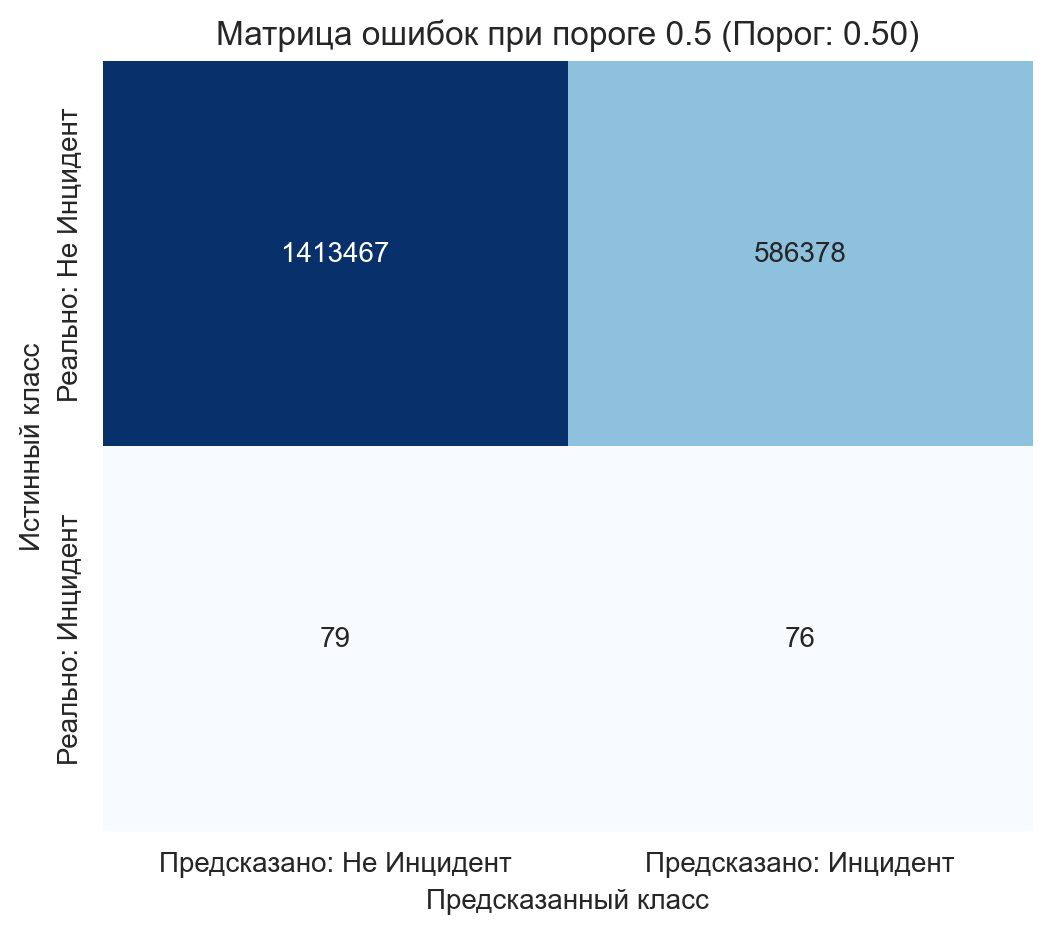

Порог, максимизирующий Recall: 0.00


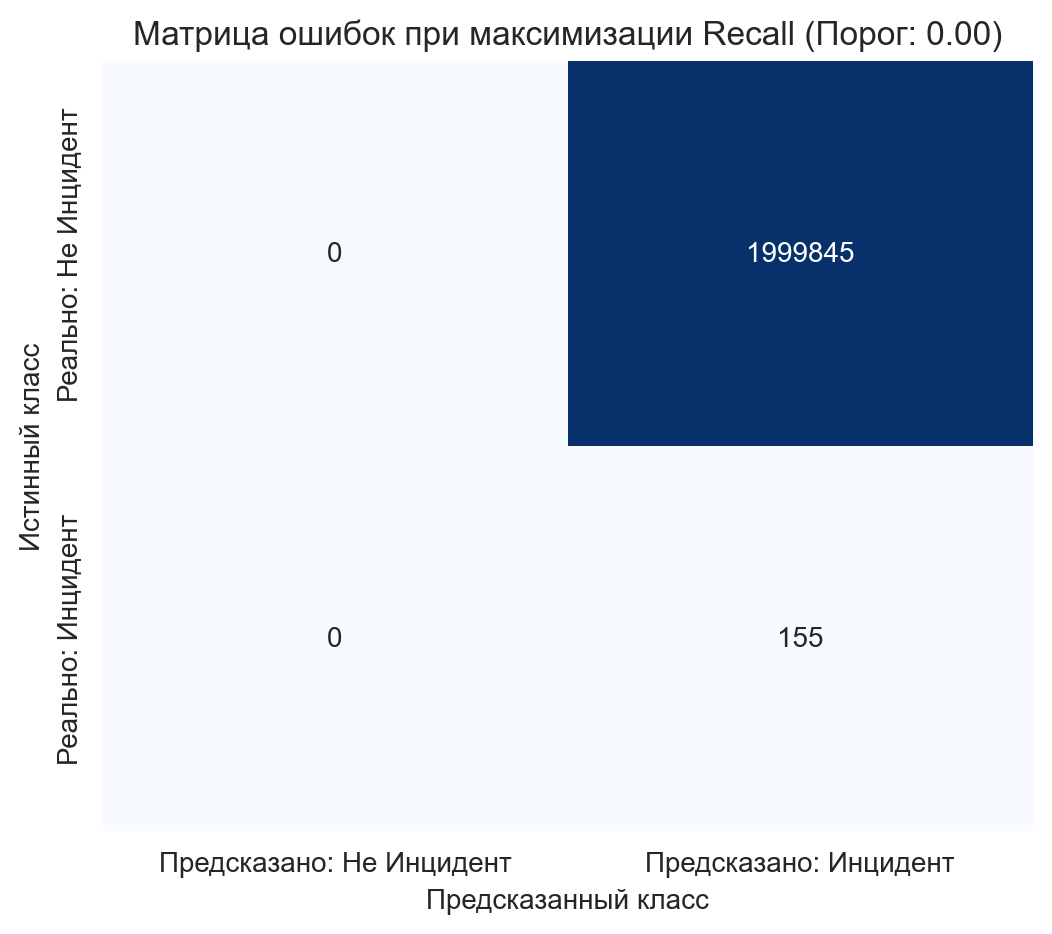

Порог, максимизирующий F1-Score: 0.98


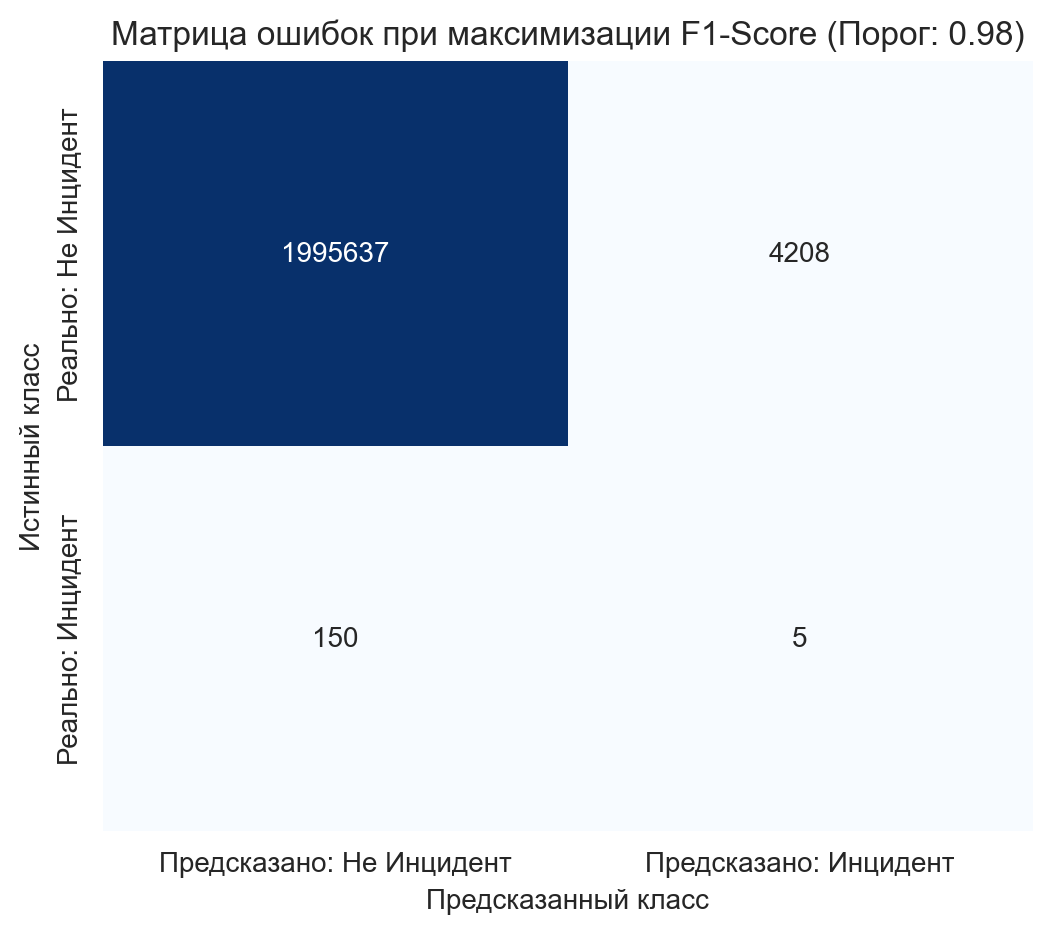

Порог для высокой Precision (пример): 0.99


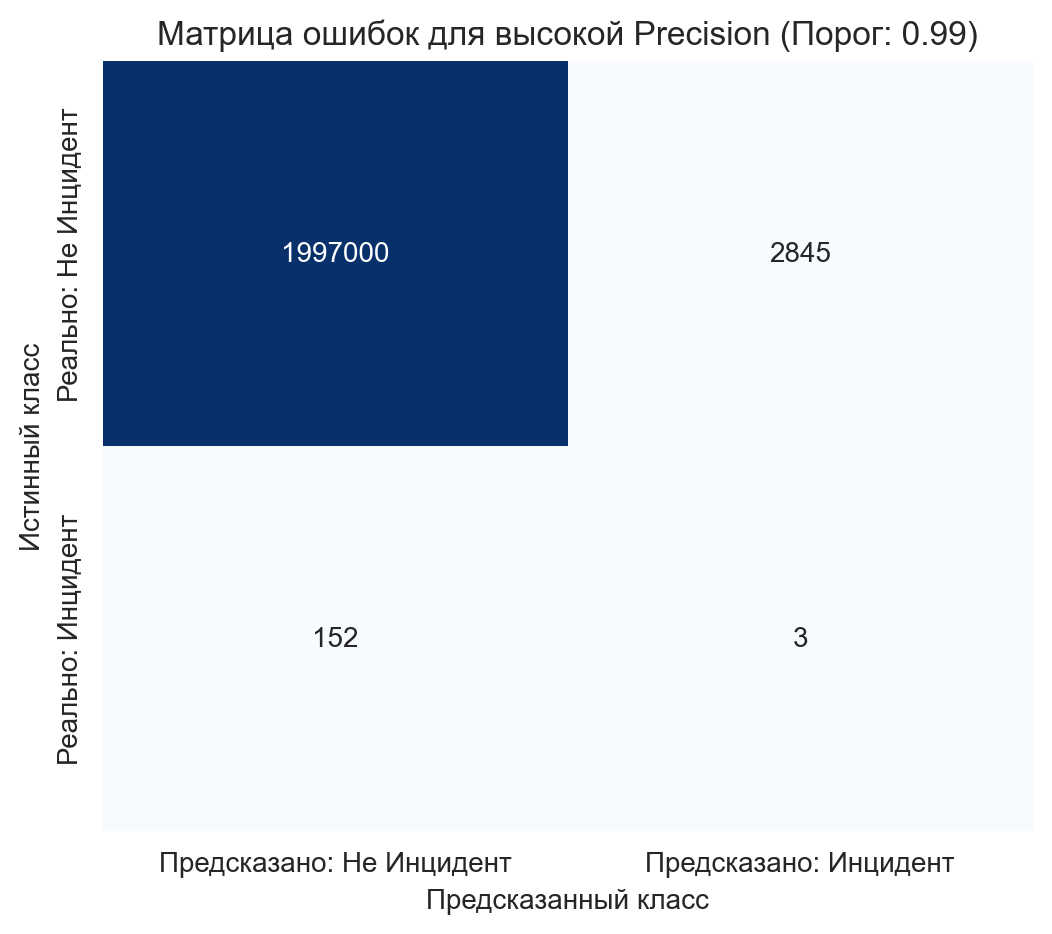


--- Анализ по бинам предсказанных вероятностей ---


,proba_bin,Всего поездок в бине,Реальных Инцидентов (TP+FN),Будет Предсказано Инцидентов (при пороге = нижней границе бина),Из них Истинно-Положительных (TP),Из них Ложно-Положительных (FP),Пропущенных Инцидентов (FN),Истинно-Отрицательных (TN)
0,"[0.0, 0.1)",255,0,255,0,255,0,0
1,"[0.1, 0.2)",95,0,95,0,95,0,0
2,"[0.2, 0.3)",305,0,305,0,305,0,0
3,"[0.3, 0.4)",693054,27,693054,27,693027,0,0
4,"[0.4, 0.5)",719837,52,719837,52,719785,0,0
5,"[0.5, 0.6)",482445,42,482445,42,482403,0,0
6,"[0.6, 0.7)",44202,6,44202,6,44196,0,0
7,"[0.7, 0.8)",28012,9,28012,9,28003,0,0
8,"[0.8, 0.9)",18325,5,18325,5,18320,0,0
9,"[0.9, 1.0)",13467,14,13467,14,13453,0,0


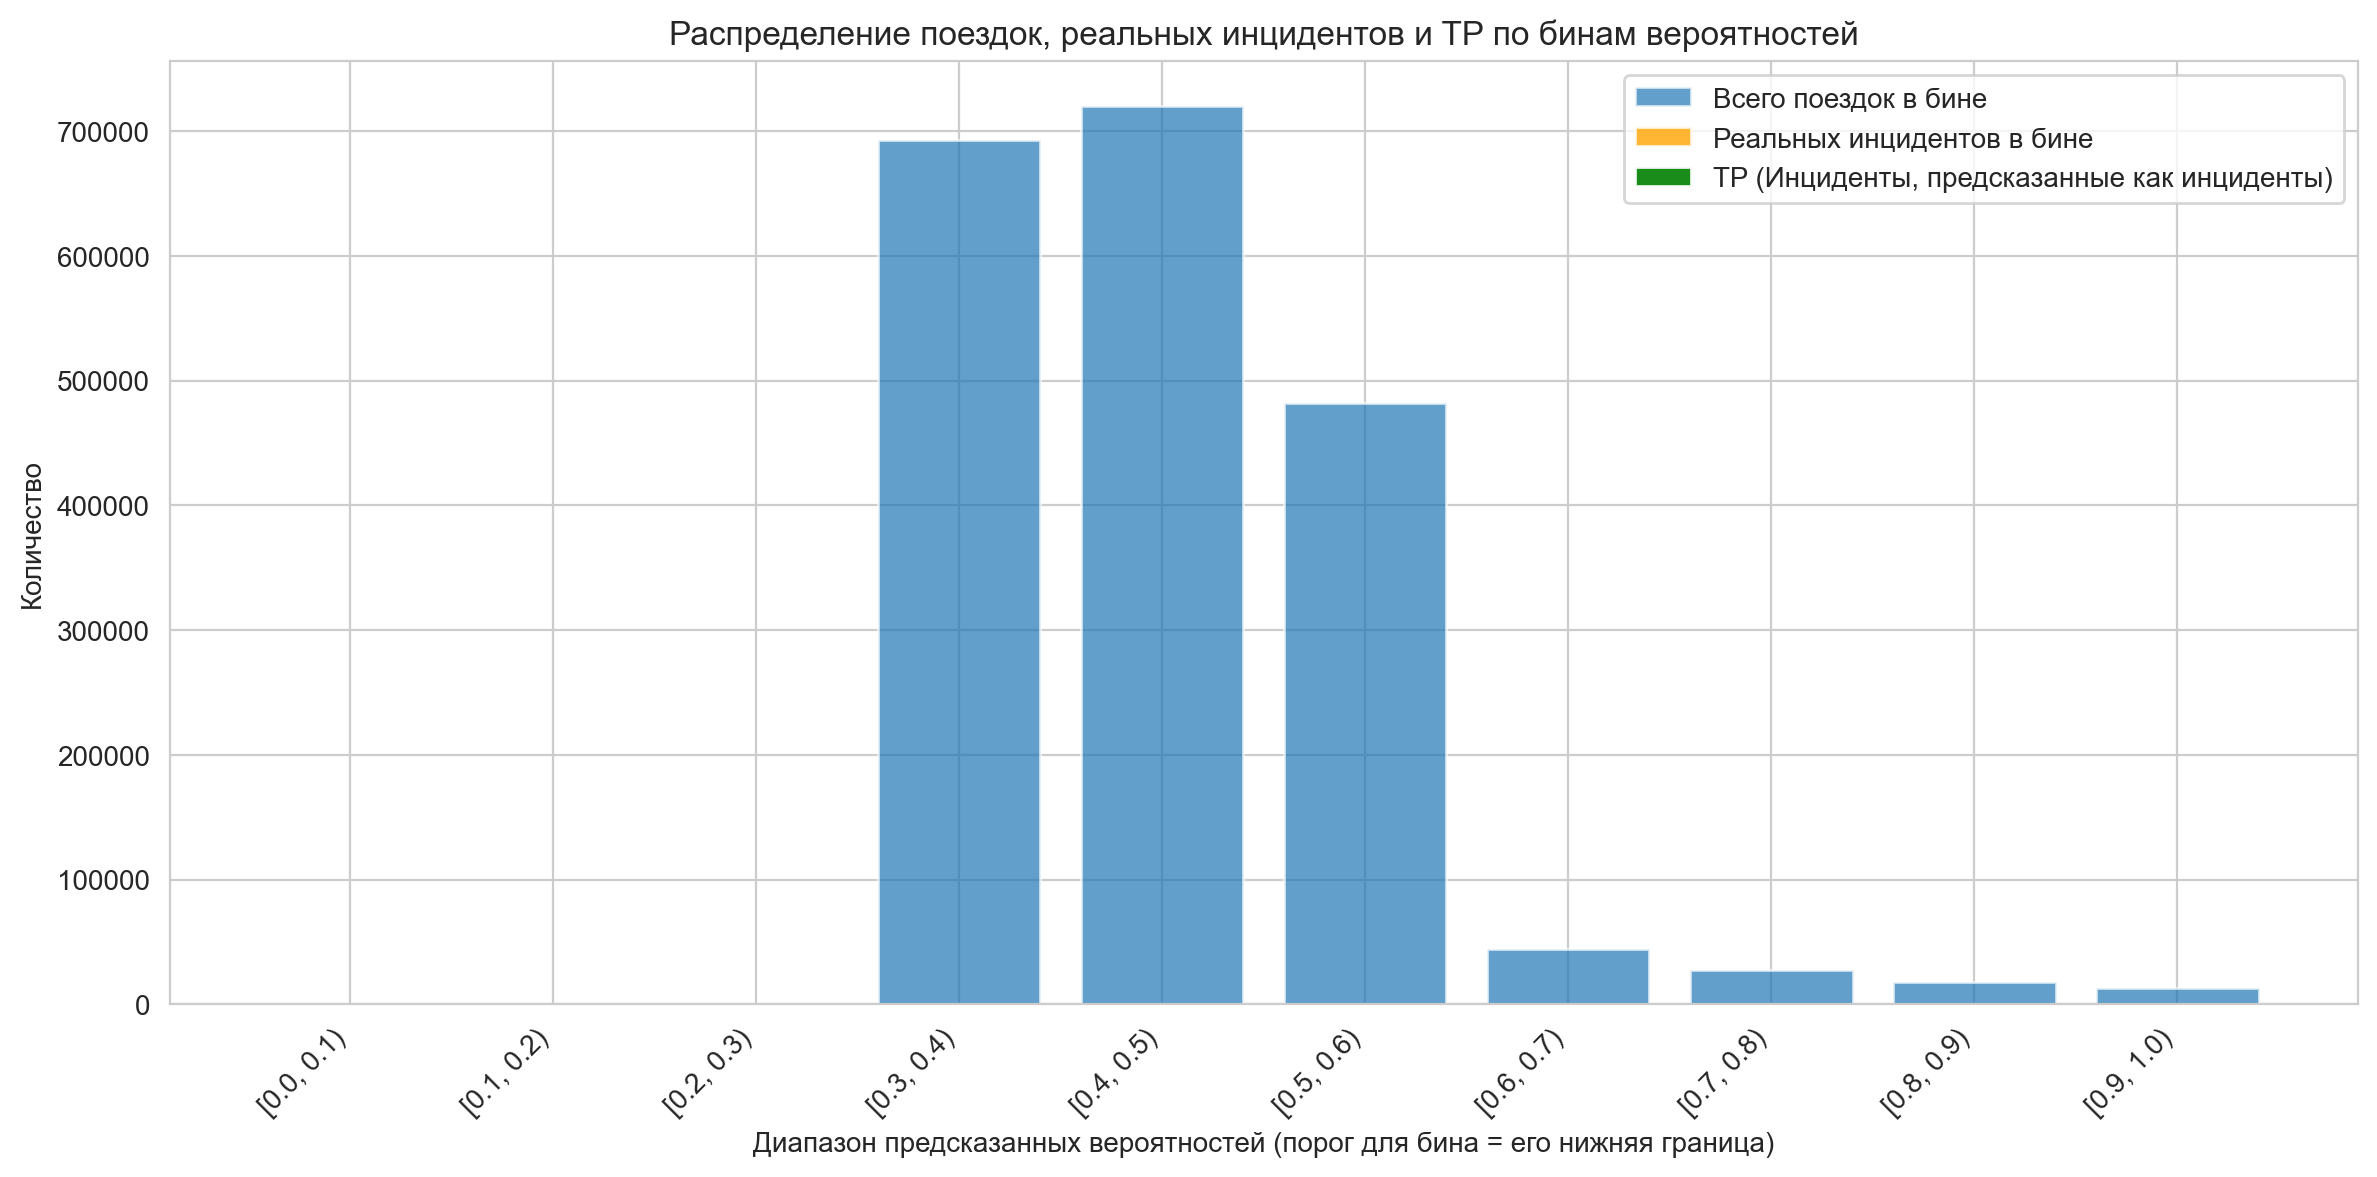


-----------------------------------------------------
Анализ завершен. Для выбора оптимального порога:
1. **Изучите коэффициенты** (веса) в Логистической регрессии, чтобы понять, какие признаки оказывают наибольшее влияние на предсказание инцидента.
2. Внимательно **изучите график 'Метрики модели в зависимости от порога'** и **таблицу метрик**.
   * **Recall (Полнота)**: Как много реальных инцидентов мы поймаем.
   * **Precision (Точность)**: Насколько часто наши уведомления будут правильными (не ложными тревогами).
   * **FPR (False Positive Rate)**: Доля ложных уведомлений среди поездок без инцидентов.
   * **FNR (False Negative Rate)**: Доля пропущенных инцидентов среди реальных инцидентов.
   * **User Notification Coverage**: Сколько всего уведомлений будет отправлено.
3. **Выберите порог**, который наилучшим образом соответствует вашим бизнес-целям и допустимому компромиссу между безопасностью (Recall) и пользовательским опытом (минимум ложных уведомлений).
4. **Анализ по бинам в

In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Установите стиль графиков для лучшей читаемости
sns.set_style("whitegrid")


# --- 2. Функции для подготовки данных, обучения модели и анализа ---

def prepare_data_for_regression(df):
    """
    Подготавливает данные для обучения логистической регрессии.
    Включает One-Hot Encoding для категориальных признаков и масштабирование числовых.

    Args:
        df (pd.DataFrame): Исходный DataFrame с данными.

    Returns:
        tuple: (X_scaled, y, feature_names_final, scaler, numerical_cols, categorical_cols_ohe)
            X_scaled (pd.DataFrame): Масштабированные признаки для обучения.
            y (pd.Series): Целевая переменная 'incident_flag'.
            feature_names_final (list): Список названий признаков после One-Hot Encoding.
            scaler (StandardScaler): Обученный Scaler для дальнейшего использования.
            numerical_cols (list): Список названий числовых признаков ДО One-Hot Encoding.
            categorical_cols_ohe (list): Список названий категориальных признаков ДО One-Hot Encoding.
    """
    target = 'incident_flag'
    y = df[target]

    columns_to_exclude = [  'ride_uuid',
                            'contractor_id',
                            'driver_reg_date',
                            'customer_id',
                            'user_reg_date',
                            'order_city_id',
                            'order_country_id',
                            'redmine_id',
                            'incident_level',
                            'information_status',
                            'incident_type',
                            'category',
                            'level_harm_health',
                            'max_seconds_of_stop',
                            'number_of_danger_zone',
                            target]

    features_raw = [col for col in df.columns if col not in columns_to_exclude]
    X_raw = df[features_raw].copy()

    categorical_cols_ohe = []
    numerical_cols = []

    for col in X_raw.columns:
        if X_raw[col].dtype == 'object':
            categorical_cols_ohe.append(col)
        elif X_raw[col].nunique() < 20 and X_raw[col].dtype in ['int64', 'float64']:
            if col not in [
                'DEVIATION_TYPE_RIDE_STOP_1',
                'DEVIATION_TYPE_RIDE_STOP_2',
                'DEVIATION_TYPE_RIDE_STOP_3',
                'RIDE_LATE_1',
                'RIDE_LATE_2',
                'RIDE_LATE_3',
                'DEVIATION_TYPE_RIDE_EARLY_1',
                'DEVIATION_TYPE_RIDE_ROUTE_CHANGES_1',
                'max_seconds_of_stop',
                'number_of_danger_zone'
                ]:
                categorical_cols_ohe.append(col)
            else:
                numerical_cols.append(col)
        else:
            numerical_cols.append(col)
    
    print(f"\nЧисловые признаки: {numerical_cols}")
    print(f"Категориальные признаки для One-Hot Encoding: {categorical_cols_ohe}")

    # Применяем One-Hot Encoding для категориальных признаков
    X_processed = pd.get_dummies(X_raw, columns=categorical_cols_ohe, drop_first=True)
    
    # Масштабирование числовых признаков
    scaler = StandardScaler()
    if numerical_cols:
        X_processed[numerical_cols] = scaler.fit_transform(X_processed[numerical_cols])

    print(f"Количество признаков после One-Hot Encoding и масштабирования: {X_processed.shape[1]}")
    
    return X_processed, y, X_processed.columns.tolist(), scaler, numerical_cols, categorical_cols_ohe

def train_logistic_regression_model(X_train, y_train):
    """
    Обучает модель Логистической Регрессии.

    Args:
        X_train (pd.DataFrame): Обучающие признаки.
        y_train (pd.Series): Обучающая целевая переменная.

    Returns:
        sklearn.linear_model.LogisticRegression: Обученная модель.
    """
    params = {
        'C': 0.1,  # Уменьшите C, чтобы увеличить регуляризацию (уменьшить веса)
        'solver': 'saga', # 'saga' подходит для больших данных и поддерживает 'class_weight'
        'class_weight': 'balanced', # Очень важно для несбалансированных классов!
        'random_state': 42,
        'n_jobs': -1, # Использовать все доступные ядра CPU
        'max_iter': 1000 # Увеличьте, если модель не сходится
    }

    print("\nНачинаем обучение модели Логистической Регрессии...")
    model = LogisticRegression(**params)
    
    model.fit(X_train, y_train)
    
    print("Обучение Логистической Регрессии завершено.")
    return model

def analyze_regression_coefficients(model, feature_names):
    """
    Анализирует и визуализирует коэффициенты обученной модели Логистической Регрессии.

    Args:
        model (sklearn.linear_model.LogisticRegression): Обученная модель.
        feature_names (list): Список названий признаков.

    Returns:
        pd.DataFrame: DataFrame с коэффициентами.
    """
    print("\n--- Анализ коэффициентов Логистической Регрессии (важность параметров) ---")
    
    coefficients_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_[0] # Коэффициенты для класса 1
    })
    
    coefficients_df.loc[len(coefficients_df)] = {'Feature': 'Intercept', 'Coefficient': model.intercept_[0]}
    
    coefficients_df['Abs_Coefficient'] = np.abs(coefficients_df['Coefficient'])
    coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)

    print("Уравнение логистической регрессии:")
    equation_parts = []
    for index, row in coefficients_df.iterrows():
        if row['Feature'] == 'Intercept':
            equation_parts.append(f"{row['Coefficient']:.4f}")
        else:
            equation_parts.append(f"{row['Coefficient']:.4f} * {row['Feature']}")
    print(f"z = {' + '.join(equation_parts)}")
    print("P(инцидент) = 1 / (1 + e^(-z))")

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=coefficients_df.head(20))
    plt.title('Коэффициенты Логистической Регрессии (Важность признаков)')
    plt.xlabel('Значение коэффициента')
    plt.ylabel('Признак')
    plt.tight_layout()
    plt.show()

    print("\nТоп-10 наиболее влиятельных признаков (по абсолютному значению коэффициента):")
    display(coefficients_df.head(10))
    
    return coefficients_df

def evaluate_and_choose_threshold(y_true, y_pred_proba, threshold_step=0.01):
    """
    Оценивает модель при различных порогах и помогает выбрать оптимальный.
    Включает FPR, FNR.

    Args:
        y_true (pd.Series): Истинные метки целевой переменной.
        y_pred_proba (np.array): Предсказанные вероятности положительного класса.
        threshold_step (float): Шаг для итерации по порогам.

    Returns:
        pd.DataFrame: DataFrame с метриками для каждого порога.
    """
    thresholds = np.arange(0, 1 + threshold_step, threshold_step)
    results = []

    print("\n--- Оценка модели по различным порогам (включая FPR, FNR) ---")
    for t in thresholds:
        y_pred = (y_pred_proba >= t).astype(int)
        
        try:
            cm = confusion_matrix(y_true, y_pred)
            tn, fp, fn, tp = cm.ravel()
        except ValueError:
            tn, fp, fn, tp = 0, 0, 0, 0

        recall = recall_score(y_true, y_pred, zero_division=0)
        precision = precision_score(y_true, y_pred, zero_division=0)
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

        user_coverage = (tp + fp) / len(y_true)
        total_trips = len(y_true)
        incidents_caught = tp

        results.append({
            'Threshold': t,
            'True Positives (TP)': tp,
            'False Positives (FP)': fp,
            'False Negatives (FN)': fn,
            'True Negatives (TN)': tn,
            'Recall (Полнота, % пойманных инцидентов)': recall * 100,
            'Precision (Точность уведомлений)': precision,
            'Accuracy': accuracy,
            'F1-Score': f1,
            'FPR (Ложные уведомления среди не-инцидентов)': fpr,
            'FNR (Пропуски среди инцидентов)': fnr,
            'User Notification Coverage (% от всех поездок)': user_coverage * 100,
            'Кол-во поездок': total_trips,
            'Кол-во пойманных инцидентов': incidents_caught
        })

    results_df = pd.DataFrame(results)

    plt.figure(figsize=(15, 8))
    plt.plot(results_df['Threshold'], results_df['Recall (Полнота, % пойманных инцидентов)'], label='Recall (%)', lw=2)
    plt.plot(results_df['Threshold'], results_df['Precision (Точность уведомлений)'], label='Precision', lw=2)
    plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy', lw=2)
    plt.plot(results_df['Threshold'], results_df['FPR (Ложные уведомления среди не-инцидентов)'], label='FPR (False Positive Rate)', lw=2, linestyle='--')
    plt.plot(results_df['Threshold'], results_df['FNR (Пропуски среди инцидентов)'], label='FNR (False Negative Rate)', lw=2, linestyle=':')
    plt.plot(results_df['Threshold'], results_df['User Notification Coverage (% от всех поездок)'], label='Охват пользователей уведомлениями (%)', lw=2)
    plt.xlabel('Порог вероятности')
    plt.ylabel('Значение метрики / %')
    plt.title('Метрики модели в зависимости от порога')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("\nТаблица метрик для различных порогов:")
    display_cols = [
        'Threshold', 'Recall (Полнота, % пойманных инцидентов)', 'Precision (Точность уведомлений)',
        'Accuracy', 'F1-Score', 'FPR (Ложные уведомления среди не-инцидентов)',
        'FNR (Пропуски среди инцидентов)', 'User Notification Coverage (% от всех поездок)',
        'Кол-во поездок', 'Кол-во пойманных инцидентов',
        'True Positives (TP)', 'False Positives (FP)', 'False Negatives (FN)', 'True Negatives (TN)'
    ]
    display(results_df[display_cols]) # Выводим всю таблицу, как вы любите
    
    optimal_f1_threshold = results_df.loc[results_df['F1-Score'].idxmax()]['Threshold']
    print(f"\nПорог, максимизирующий F1-Score: {optimal_f1_threshold:.2f}")

    # Добавляем соотношение FNR и Recall для удобства принятия решения
    print("\nСоотношение FNR и Recall (FNR = 1 - Recall/100):")
    results_df['FNR_from_Recall'] = 1 - results_df['Recall (Полнота, % пойманных инцидентов)'] / 100
    display(results_df[['Threshold', 'Recall (Полнота, % пойманных инцидентов)', 'FNR (Пропуски среди инцидентов)', 'FNR_from_Recall']].head(10))
    print("FNR и Recall являются обратными метриками. FNR показывает долю пропущенных инцидентов, а Recall - долю пойманных.")
    print("Чем ниже FNR, тем выше Recall, и тем лучше модель ловит инциденты.")

    return results_df

def plot_confusion_matrix_for_threshold(y_true, y_pred_proba, threshold, title="Матрица ошибок"):
    """
    Отрисовывает матрицу ошибок для заданного порога.
    """
    y_pred = (y_pred_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Предсказано: Не Инцидент', 'Предсказано: Инцидент'],
                yticklabels=['Реально: Не Инцидент', 'Реально: Инцидент'])
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.title(f'{title} (Порог: {threshold:.2f})')
    plt.show()

def analyze_by_probability_bins(y_true, y_pred_proba, num_bins=10):
    """
    Анализирует количество поездок и инцидентов по бинам предсказанных вероятностей.

    Args:
        y_true (pd.Series): Истинные метки целевой переменной.
        y_pred_proba (np.array): Предсказанные вероятности положительного класса.
        num_bins (int): Количество бинов для разбиения вероятностей.
    """
    print("\n--- Анализ по бинам предсказанных вероятностей ---")
    df_results = pd.DataFrame({'true_label': y_true, 'predicted_proba': y_pred_proba})

    bins = np.linspace(0, 1, num_bins + 1)
    df_results['proba_bin'] = pd.cut(df_results['predicted_proba'], bins=bins, include_lowest=True, right=False)

    # Исправлено: доступ к нижней границе бина через iloc[0]
    grouped = df_results.groupby('proba_bin').apply(lambda x: pd.Series({
        'Всего поездок в бине': len(x),
        'Реальных Инцидентов (TP+FN)': x['true_label'].sum(), 
        'Будет Предсказано Инцидентов (при пороге = нижней границе бина)': (x['predicted_proba'] >= x['proba_bin'].iloc[0].left).sum(),
        'Из них Истинно-Положительных (TP)': ((x['predicted_proba'] >= x['proba_bin'].iloc[0].left) & (x['true_label'] == 1)).sum(),
        'Из них Ложно-Положительных (FP)': ((x['predicted_proba'] >= x['proba_bin'].iloc[0].left) & (x['true_label'] == 0)).sum(),
        'Пропущенных Инцидентов (FN)': ((x['predicted_proba'] < x['proba_bin'].iloc[0].left) & (x['true_label'] == 1)).sum(),
        'Истинно-Отрицательных (TN)': ((x['predicted_proba'] < x['proba_bin'].iloc[0].left) & (x['true_label'] == 0)).sum()
    })).reset_index()

    display(grouped)

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(grouped)), grouped['Всего поездок в бине'], label='Всего поездок в бине', alpha=0.7)
    plt.bar(range(len(grouped)), grouped['Реальных Инцидентов (TP+FN)'], label='Реальных инцидентов в бине', alpha=0.8, color='orange')
    plt.bar(range(len(grouped)), grouped['Из них Истинно-Положительных (TP)'], label='TP (Инциденты, предсказанные как инциденты)', alpha=0.9, color='green')

    plt.xticks(range(len(grouped)), [str(b) for b in grouped['proba_bin']], rotation=45, ha='right')
    plt.xlabel('Диапазон предсказанных вероятностей (порог для бина = его нижняя граница)')
    plt.ylabel('Количество')
    plt.title('Распределение поездок, реальных инцидентов и TP по бинам вероятностей')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- 3. Главная функция запуска ---
def main():
    # Используем глобальный DataFrame 'df', который должен быть загружен вами
    # Если вы используете свой реальный df, убедитесь, что он доступен.
    
    # 1. Подготовка данных для регрессии
    X_processed, y, feature_names_final, scaler, numerical_cols, categorical_cols_ohe = prepare_data_for_regression(df_itm_1mln.copy())

    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\nРазмер обучающей выборки: {len(X_train)} строк.")
    print(f"Размер тестовой выборки: {len(X_test)} строк.")
    print(f"Доля инцидентов в обучающей выборке: {y_train.sum() / len(y_train):.4f}")
    print(f"Доля инцидентов в тестовой выборке: {y_test.sum() / len(y_test):.4f}")

    # *** ВАЖНО: Если у вас 60 млн строк, X_train будет 48 млн.
    # *** Логистическая регрессия также может быть медленной на таком объеме.
    # *** Рассмотрите возможность обучения на выборке для ускорения:
    # sample_size_for_training = 1000000 # Например, 1 миллион строк
    # if len(X_train) > sample_size_for_training:
    #     print(f"Обучаем модель на выборке из {sample_size_for_training} строк для скорости.")
    #     X_train_for_model = X_train.sample(n=sample_size_for_training, random_state=42)
    #     y_train_for_model = y_train.loc[X_train_for_model.index]
    # else:
    #     X_train_for_model = X_train
    #     y_train_for_model = y_train
    # model = train_logistic_regression_model(X_train_for_model, y_train_for_model)

    # 2. Обучение модели Логистической Регрессии (используя весь X_train)
    model = train_logistic_regression_model(X_train, y_train)

    # Прогноз вероятностей на тестовой выборке
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # 3. Анализ весов (коэффициентов) и уравнение
    coefficients_df = analyze_regression_coefficients(model, feature_names_final)

    # 4. Оценка модели и выбор порога с новой таблицей
    results_df = evaluate_and_choose_threshold(y_test, y_pred_proba)

    print("\n--- Визуализация матриц ошибок для различных сценариев ---")
    
    plot_confusion_matrix_for_threshold(y_test, y_pred_proba, 0.5, "Матрица ошибок при пороге 0.5")
    
    max_recall_threshold = results_df.loc[results_df['Recall (Полнота, % пойманных инцидентов)'].idxmax()]['Threshold']
    print(f"Порог, максимизирующий Recall: {max_recall_threshold:.2f}")
    plot_confusion_matrix_for_threshold(y_test, y_pred_proba, max_recall_threshold, "Матрица ошибок при максимизации Recall")
    
    max_f1_threshold = results_df.loc[results_df['F1-Score'].idxmax()]['Threshold']
    print(f"Порог, максимизирующий F1-Score: {max_f1_threshold:.2f}")
    plot_confusion_matrix_for_threshold(y_test, y_pred_proba, max_f1_threshold, "Матрица ошибок при максимизации F1-Score")
    
    high_precision_threshold = results_df[results_df['Precision (Точность уведомлений)'] > 0.8]['Threshold'].max()
    if pd.isna(high_precision_threshold) or high_precision_threshold < 0.1:
        high_precision_threshold = results_df['Threshold'].iloc[-2]
    print(f"Порог для высокой Precision (пример): {high_precision_threshold:.2f}")
    plot_confusion_matrix_for_threshold(y_test, y_pred_proba, high_precision_threshold, "Матрица ошибок для высокой Precision")


    # Реализация вашей идеи: анализ по бинам предсказанных вероятностей
    analyze_by_probability_bins(y_test, y_pred_proba, num_bins=10)

    print("\n-----------------------------------------------------")
    print("Анализ завершен. Для выбора оптимального порога:")
    print("1. **Изучите коэффициенты** (веса) в Логистической регрессии, чтобы понять, какие признаки оказывают наибольшее влияние на предсказание инцидента.")
    print("2. Внимательно **изучите график 'Метрики модели в зависимости от порога'** и **таблицу метрик**.")
    print("   * **Recall (Полнота)**: Как много реальных инцидентов мы поймаем.")
    print("   * **Precision (Точность)**: Насколько часто наши уведомления будут правильными (не ложными тревогами).")
    print("   * **FPR (False Positive Rate)**: Доля ложных уведомлений среди поездок без инцидентов.")
    print("   * **FNR (False Negative Rate)**: Доля пропущенных инцидентов среди реальных инцидентов.")
    print("   * **User Notification Coverage**: Сколько всего уведомлений будет отправлено.")
    print("3. **Выберите порог**, который наилучшим образом соответствует вашим бизнес-целям и допустимому компромиссу между безопасностью (Recall) и пользовательским опытом (минимум ложных уведомлений).")
    print("4. **Анализ по бинам вероятностей** поможет понять, как распределены ваши предсказания и где находятся реальные инциденты относительно предсказанных вероятностей.")
    
    # --- Вывод уравнения для команды разработки ---
    print("\n\n--- УРАВНЕНИЕ МОДЕЛИ ДЛЯ КОМАНДЫ РАЗРАБОТКИ ---")
    print("Это уравнение поможет вычислить 'сырое' значение (z), которое затем преобразуется в вероятность.")
    print("Для его использования входные данные ДОЛЖНЫ БЫТЬ ПРЕДОБРАБОТАНЫ ТАК ЖЕ, как и для обучения модели.")
    print("Это включает One-Hot Encoding для категориальных признаков и СТАНДАРТНОЕ МАШТАБИРОВАНИЕ для числовых признаков.")

    # Создаем строку для z
    z_equation_parts = []
    for index, row in coefficients_df.iterrows():
        if row['Feature'] == 'Intercept':
            z_equation_parts.append(f"{row['Coefficient']:.6f}") # Свободный член
        else:
            z_equation_parts.append(f"{row['Coefficient']:.6f} * {row['Feature']}") # Коэффициент * Признак

    z_equation = " + ".join(z_equation_parts)
    print(f"\n1. Формула для вычисления Z (логарифма шансов):\n   Z = {z_equation}")
    print("\n   Где 'Feature' - это названия признаков, после их предобработки (One-Hot Encoding и масштабирования).")

    print("\n2. Формула для преобразования Z в вероятность инцидента (P_incident):\n   P_incident = 1 / (1 + exp(-Z))")
    print("\n   exp() - это экспоненциальная функция (e в степени).")

    print("\n3. Принятие решения об отправке пуш-уведомления:")
    print(f"   Если P_incident >= [ВАШ ВЫБРАННЫЙ ПОРОГ], то отправляем уведомление.")
    print(f"   Например, если вы выбрали порог {max_f1_threshold:.4f} (максимизирующий F1-Score), то:")
    print(f"   Если P_incident >= {max_f1_threshold:.4f}, то отправляем уведомление.")
    print("\n--- ДЕТАЛИ ПРЕДОБРАБОТКИ ВХОДНЫХ ДАННЫХ ДЛЯ РАЗРАБОТКИ ---")
    print("Команда разработки должна выполнить следующие шаги для каждой новой поездки:")
    print("1. **Исключить** идентификаторы и информацию об инциденте (ride_uuid, contractor_id, customer_id, redmine_id, incident_level, information_status, incident_type, category, level_harm_health).")
    print("2. **Обработать отсутствующие значения:** заполнить 0 (как вы уже делаете).")
    print("3. **Категориальные признаки (One-Hot Encoding):**")
    print(f"   Признаки: {categorical_cols_ohe}")
    print("   Для каждого из этих признаков нужно создать новые бинарные признаки (0 или 1) для каждой уникальной категории.")
    print("   Например, если 'order_city_id' был 1, 2, 3, то станут 'order_city_id_2', 'order_city_id_3'.")
    print("   Если оригинальное значение 'order_city_id' было 1, то 'order_city_id_2'=0, 'order_city_id_3'=0.")
    print("   Используйте те же колонки, что и в X_processed (упомянутые в feature_names_final).")
    print("4. **Числовые признаки (Стандартное масштабирование):**")
    print(f"   Признаки: {numerical_cols}")
    print("   Для каждого из этих признаков нужно применить стандартное масштабирование (StandardScaler).")
    print("   Это означает: `(значение - среднее) / стандартное_отклонение`.")
    print("   **ВНИМАНИЕ:** Использовать нужно те же средние значения и стандартные отклонения, которые были рассчитаны на ОБУЧАЮЩИХ ДАННЫХ.")
    print("   Для этого нужно сохранить объекты `LabelEncoder` (если использовались для object типов) и `StandardScaler` (объект `scaler`)")
    print("   и использовать их методы `.transform()` для новых данных.")
    print("   `scaler` - это объект, который был возвращен функцией `prepare_data_for_regression`.")
    
    return model, results_df, X_test, y_test, y_pred_proba, coefficients_df, scaler, feature_names_final, numerical_cols, categorical_cols_ohe

# Запускаем основной блок кода
if __name__ == "__main__":
    model_output = main() 

    # Если main() успешно вернула значения, распаковываем их
    if model_output:
        model, results_df, X_test, y_test, y_pred_proba, coefficients_df, scaler, feature_names_final, numerical_cols, categorical_cols_ohe = model_output
        print("\nПеременные модели доступны для дальнейшего исследования (например, введите results_df.head() в новой ячейке).")

In [ ]:
# {
#   "model_type": "LogisticRegression",
#   "chosen_threshold": 0.1500, // Порог для отправки
#   "model_equation": {
#     "intercept": -0.324971, // Свободный член уравнения
#     "coefficients": [
#       {"feature": "danger_zone_flag", "value": -1.875600},
#       {"feature": "night_time_flg", "value": 0.522855},
#       {"feature": "DEVIATION_TYPE_RIDE_STOP_3", "value": 0.171547},
#       {"feature": "DEVIATION_TYPE_RIDE_STOP_1", "value": 0.129791},
#       {"feature": "DEVIATION_TYPE_RIDE_STOP_2", "value": 0.227115},
#       {"feature": "DEVIATION_TYPE_RIDE_EARLY_1", "value": -0.087351},
#       {"feature": "DEVIATION_TYPE_RIDE_ROUTE_CHANGES_1", "value": -0.026727},
#     ]
#   }

In [25]:
df.columns

Index(['ride_uuid', 'night_time_flg', 'contractor_id', 'driver_reg_date', 'customer_id', 'user_reg_date', 'order_city_id', 'order_country_id', 'DEVIATION_TYPE_RIDE_STOP_1', 'DEVIATION_TYPE_RIDE_STOP_2', 'DEVIATION_TYPE_RIDE_STOP_3', 'RIDE_LATE_1', 'RIDE_LATE_2', 'RIDE_LATE_3', 'DEVIATION_TYPE_RIDE_EARLY_1', 'DEVIATION_TYPE_RIDE_ROUTE_CHANGES_1', 'max_seconds_of_stop', 'danger_zone_flag', 'number_of_danger_zone', 'incident_flag', 'redmine_id', 'incident_level', 'information_status', 'incident_type', 'category', 'level_harm_health'], dtype='object')

In [60]:
df_agg_all = df.groupby(
    ['night_time_flg', 'DEVIATION_TYPE_RIDE_STOP_1', 'DEVIATION_TYPE_RIDE_STOP_2', 'DEVIATION_TYPE_RIDE_STOP_3', 'RIDE_LATE_1', 'RIDE_LATE_2', 'RIDE_LATE_3', 'DEVIATION_TYPE_RIDE_EARLY_1', 'DEVIATION_TYPE_RIDE_ROUTE_CHANGES_1', 'danger_zone_flag'],
    as_index=False
)[['ride_uuid', 'incident_flag']].agg({
    'ride_uuid':'count',
    'incident_flag':'sum'
})

In [76]:
columns_to_sum = ['night_time_flg', 'DEVIATION_TYPE_RIDE_STOP_1', 'DEVIATION_TYPE_RIDE_STOP_2', 'DEVIATION_TYPE_RIDE_STOP_3', 'RIDE_LATE_1', 'RIDE_LATE_2', 'RIDE_LATE_3', 'DEVIATION_TYPE_RIDE_EARLY_1', 'DEVIATION_TYPE_RIDE_ROUTE_CHANGES_1','danger_zone_flag']

df_agg_all['composite'] = df_agg_all[columns_to_sum].sum(axis=1)

df_agg_all['equation'] = -1.875600 * df_agg_all['danger_zone_flag'] + 0.522855 * df_agg_all['night_time_flg'] + -0.324971*1 + 0.227115 * df_agg_all['DEVIATION_TYPE_RIDE_STOP_2'] + 0.206078 * df_agg_all['DEVIATION_TYPE_RIDE_STOP_3'] + 0.171547 * df_agg_all['DEVIATION_TYPE_RIDE_STOP_1'] + -0.087351 * df_agg_all['DEVIATION_TYPE_RIDE_EARLY_1'] + -0.026727 * df_agg_all['DEVIATION_TYPE_RIDE_ROUTE_CHANGES_1'] + 0.000000 * df_agg_all['RIDE_LATE_1'] + 0.000000 * df_agg_all['RIDE_LATE_2'] + 0.000000 * df_agg_all['RIDE_LATE_3']

df_agg_all['probabilty'] = (1 / (1 + np.exp(df_agg_all['equation'])))*100

df_agg_all['ir'] = (df_agg_all['incident_flag'] / df_agg_all['ride_uuid'])*100


df_agg_all.query("ride_uuid < 100000").sort_values('incident_flag', ascending=False).head(30)

,night_time_flg,DEVIATION_TYPE_RIDE_STOP_1,DEVIATION_TYPE_RIDE_STOP_2,DEVIATION_TYPE_RIDE_STOP_3,RIDE_LATE_1,RIDE_LATE_2,RIDE_LATE_3,DEVIATION_TYPE_RIDE_EARLY_1,DEVIATION_TYPE_RIDE_ROUTE_CHANGES_1,danger_zone_flag,ride_uuid,incident_flag,composite,equation,probabilty,ir
39386,1,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,56984,38,4.0000,0.8026,30.9464,0.0667
3420,0,2.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,66354,35,4.0000,0.4513,38.9048,0.0527
40519,1,2.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,29192,27,5.0000,0.9742,27.4050,0.0925
40250,1,2.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,80474,22,4.0000,0.7681,31.6892,0.0273
41210,1,2.0000,2.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9983,19,7.0000,1.4074,19.6650,0.1903
1960,0,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,42983,16,4.0000,0.2530,43.7075,0.0372
42037,1,3.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,13113,14,6.0000,1.1457,24.1272,0.1068
10059,0,5.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,67268,14,5.0000,0.5328,36.9872,0.0208
3848,0,2.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,46397,14,4.0000,0.4724,38.4059,0.0302
6365,0,3.0000,2.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8548,13,7.0000,1.0561,25.8064,0.1521


In [79]:
results_df

,Threshold,True Positives (TP),False Positives (FP),False Negatives (FN),True Negatives (TN),"Recall (Полнота, % пойманных инцидентов)",Precision (Точность уведомлений),Accuracy,F1-Score,FPR (Ложные уведомления среди не-инцидентов),FNR (Пропуски среди инцидентов),User Notification Coverage (% от всех поездок),Кол-во поездок,Кол-во пойманных инцидентов,FNR_from_Recall
0,0.0000,155,1999845,0,0,100.0000,0.0001,0.0001,0.0002,1.0000,0.0000,100.0000,2000000,155,0.0000
1,0.0100,155,1999699,0,146,100.0000,0.0001,0.0002,0.0002,0.9999,0.0000,99.9927,2000000,155,0.0000
2,0.0200,155,1999679,0,166,100.0000,0.0001,0.0002,0.0002,0.9999,0.0000,99.9917,2000000,155,0.0000
3,0.0300,155,1999659,0,186,100.0000,0.0001,0.0002,0.0002,0.9999,0.0000,99.9907,2000000,155,0.0000
4,0.0400,155,1999646,0,199,100.0000,0.0001,0.0002,0.0002,0.9999,0.0000,99.9900,2000000,155,0.0000
5,0.0500,155,1999635,0,210,100.0000,0.0001,0.0002,0.0002,0.9999,0.0000,99.9895,2000000,155,0.0000
6,0.0600,155,1999627,0,218,100.0000,0.0001,0.0002,0.0002,0.9999,0.0000,99.9891,2000000,155,0.0000
7,0.0700,155,1999617,0,228,100.0000,0.0001,0.0002,0.0002,0.9999,0.0000,99.9886,2000000,155,0.0000
8,0.0800,155,1999599,0,246,100.0000,0.0001,0.0002,0.0002,0.9999,0.0000,99.9877,2000000,155,0.0000
9,0.0900,155,1999597,0,248,100.0000,0.0001,0.0002,0.0002,0.9999,0.0000,99.9876,2000000,155,0.0000


In [81]:
df_agg_all.head()

,night_time_flg,DEVIATION_TYPE_RIDE_STOP_1,DEVIATION_TYPE_RIDE_STOP_2,DEVIATION_TYPE_RIDE_STOP_3,RIDE_LATE_1,RIDE_LATE_2,RIDE_LATE_3,DEVIATION_TYPE_RIDE_EARLY_1,DEVIATION_TYPE_RIDE_ROUTE_CHANGES_1,danger_zone_flag,ride_uuid,incident_flag,composite,equation,probabilty,ir
0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1316679,78,0.0000,-0.3250,58.0535,0.0059
1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,8171902,354,1.0000,-0.3517,58.7029,0.0043
2,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,4996239,177,2.0000,-0.3784,59.3493,0.0035
3,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,1566521,62,3.0000,-0.4052,59.9925,0.0040
4,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,1466372,71,4.0000,-0.4319,60.6322,0.0048


In [82]:
writing_excel('data', df_agg_all, results_df)

DataFrame is written to Excel File successfully.


# Coefficient adjusting

In [ ]:
# danger_zone_flag:
#   value: 0
# night_time_flg:
#   value: 0.522855
# ride_stop_1:
#   value: 0.129791
# ride_stop_2:
#   value: 0.227115
# ride_stop_3:
#   value: 0.171547
# ride_early:
#   value: -0.087351
# ride_route_changed:
#   value: 0.0

# threshold: 0.51

In [11]:
import math
threshold = 0.65

features = {
    "night_time_flg": 0.522855,
    "ride_stop_1": 0.129791,
    "ride_stop_2": 0.227115,
    "ride_stop_3": 0.171547,
    }

night_time_flg = 0 # binary
ride_stop_1 = 1
ride_stop_2 = 1
ride_stop_3 = 1
ride_deviation = 0

Y = 0.5*night_time_flg + 0.13*ride_stop_1 + 0.23*ride_stop_2 + 0.3*ride_stop_3 + 0.1*ride_deviation
# Y = 0.522855*night_time_flg + 0.129791*ride_stop_1 + 0.227115*ride_stop_2 + 0.171547*ride_stop_3

prob = (1 / (1 + math.exp(-Y)))

print(f"{15*'-'} Values: {15*'-'}")
print(f"Probability = {prob:.3f} <--")
print(f"Threshold = {threshold}")
print(f"{15*'-'} Parameters: {15*'-'}")
print(f"night_time_flg: {night_time_flg}")
print(f"ride_stop_1: {ride_stop_1}")
print(f"ride_stop_2: {ride_stop_2}")
print(f"ride_stop_3: {ride_stop_3}")
print(f"ride_stop_3: {ride_deviation}")



--------------- Values: ---------------
Probability = 0.659 <--
Threshold = 0.65
--------------- Parameters: ---------------
night_time_flg: 0
ride_stop_1: 1
ride_stop_2: 1
ride_stop_3: 1
ride_stop_3: 0
